# Modélisation Prédictive et Analyse Comparative

Ce notebook constitue la première phase de modélisation de notre étude sur les températures parisiennes. Il s'appuie directement sur les diagnostics structurels établis dans le **Notebook 3 (Analyse des Séries Temporelles)**.

### Objectifs de Recherche
Notre objectif est de construire des modèles stochastiques capables de prévoir la température horaire ($T_{2m}$). Nous adoptons une approche de complexité croissante pour valider statistiquement l'apport de chaque modèle :
1.  **Modélisation Baseline :** Établir un seuil de performance minimal via une approche naïve.
2.  **Modélisation Paramétrique (SARIMA) :** Implémenter un modèle linéaire capturant la structure auto-corrélée identifiée précédemment.
3.  **Protocole d'Évaluation :** Comparer les prévisions "statiques" (horizon long) aux prévisions "dynamiques" (mise à jour en temps réel) pour simuler des contraintes opérationnelles réelles.

### Synthèse des Hypothèses issues du Notebook 3
Les tests statistiques (KPSS, ACF/PACF) du notebook précédent imposent les contraintes structurelles suivantes :
* **Stationnarité :** La série brute étant non-stationnaire, nous appliquons une double intégration : simple ($d=1$) et saisonnière ($D=1$).
* **Saisonnalité :** Le cycle dominant est diurne, fixant la période à $s=24$.
* **Limites Théoriques :** L'analyse par Heatmap a révélé une non-linéarité (variance saisonnière) que le modèle SARIMA (linéaire) peinera à capturer parfaitement sur le long terme, justifiant l'exploration future de réseaux de neurones (LSTM).

In [1]:
#Importation des bibliothèques

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Prépartaion des données

data_path = "data/hourly_data.csv"
df = pd.read_csv(data_path)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

temperature = df['temperature_2m']
display(temperature.head())

time
2000-01-01 00:00:00    6.0
2000-01-01 01:00:00    6.0
2000-01-01 02:00:00    5.9
2000-01-01 03:00:00    6.0
2000-01-01 04:00:00    6.1
Name: temperature_2m, dtype: float64

## Partitionnement Chronologique

Contrairement aux problèmes d'apprentissage supervisé classiques, l'analyse de séries temporelles interdit le mélange aléatoire (*shuffling*) des données. Pour garantir une évaluation honnête et éviter toute "fuite de données" (*data leakage*), nous respectons strictement la flèche du temps.

### Stratégie de Découpage
* **Ensemble d'Entraînement ($D_{train}$) :** Les premiers 80% de l'historique. Cet ensemble est utilisé pour l'estimation des paramètres du modèle ($\hat{\theta}$).
* **Ensemble de Test ($D_{test}$) :** Les derniers 20% de l'historique. Ces données sont "invisibles" au modèle durant l'entraînement et servent uniquement à la validation hors-échantillon (*out-of-sample*).

Période d'Entraînement : 2000-01-01 00:00:00 à 2020-08-26 23:00:00
Nombre d'observations  : 181056

Période de Test        : 2020-08-27 00:00:00 à 2025-10-25 23:00:00
Nombre d'observations  : 45264


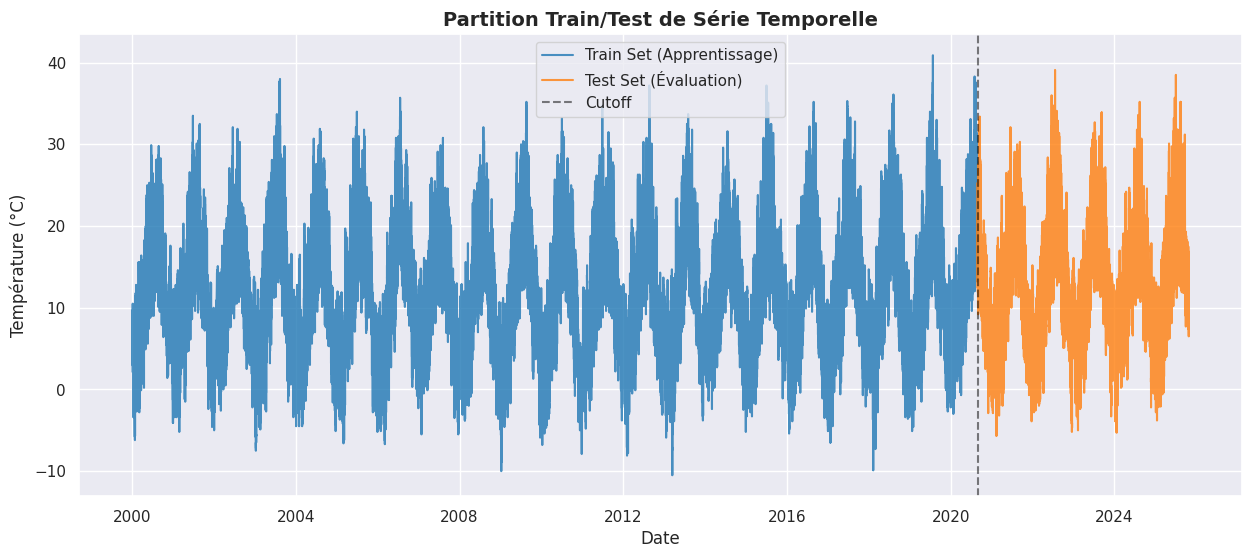

In [3]:
#Séparation Train / Test (80% Train, 20% Test)

train_size = int(len(temperature) * 0.8)
train_data, test_data = temperature.iloc[:train_size], temperature.iloc[train_size:]

print(f"Période d'Entraînement : {train_data.index.min()} à {train_data.index.max()}")
print(f"Nombre d'observations  : {len(train_data)}")
print(f"\nPériode de Test        : {test_data.index.min()} à {test_data.index.max()}")
print(f"Nombre d'observations  : {len(test_data)}")

# Visualisation de la partition
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data, label='Train Set (Apprentissage)', color='#1f77b4', alpha=0.8)
plt.plot(test_data.index, test_data, label='Test Set (Évaluation)', color='#ff7f0e', alpha=0.8)
plt.axvline(train_data.index[-1], color='black', linestyle='--', alpha=0.5, label='Cutoff')
plt.title("Partition Train/Test de Série Temporelle", fontsize=14, fontweight='bold')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.show()

In [4]:
# Définition de la fonction d'évaluation (RMSE et MAE)

def evaluate_forecast(y_true, y_pred, model_name="Modèle"):
    """
    Calcule et affiche les métriques de performance (RMSE, MAE).
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"--- Performance : {model_name} ---")
    print(f"RMSE : {rmse:.4f} °C")
    print(f"MAE  : {mae:.4f} °C")
    
    return rmse, mae

In [5]:
# Dictionnaire pour stocker les résultats de tous les modèles

results_comparison = {}

## Modèle Baseline : La Persistance Saisonnière

Avant d'entraîner des modèles complexes, il est impératif de définir une "ligne de base" (*benchmark*). Dans le contexte de données météorologiques à haute fréquence, la méthode de persistance est souvent redoutable à court terme.

**Hypothèse ($H_0$) :** La meilleure prédiction pour l'heure $t$ est la température observée à la même heure la veille ($t-24$).

**Formulation Mathématique :**
$$\hat{y}_{t} = y_{t-24}$$

Ce modèle capture implicitement le cycle journalier sans aucun paramètre à apprendre. Tout modèle statistique avancé (SARIMA, LSTM) devra surpasser significativement cette baseline (RMSE plus faible) pour justifier son coût computationnel.

--- Performance : Baseline naif ---
RMSE : 2.7864 °C
MAE  : 2.1300 °C


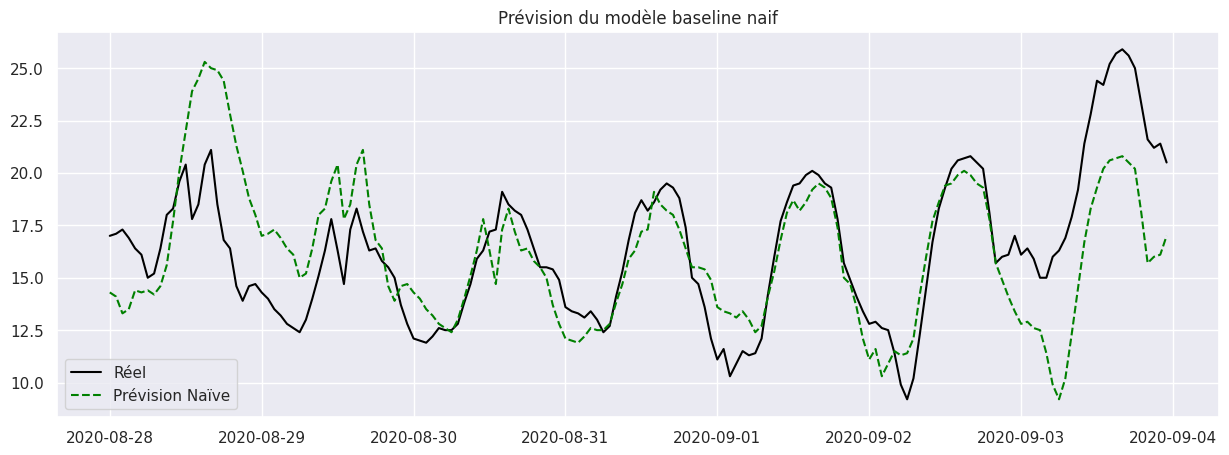

In [6]:
# Cellule : Baseline Naïve (Persistance Saisonnière 24h)

# Création de la prévision naïve (shift de 24h)
# Pour le jeu de test, la prédiction à t est la valeur réelle à t-24
naive_forecast = test_data.shift(24).dropna()
# On aligne le y_true pour correspondre aux indices disponibles
y_true_naive = test_data.loc[naive_forecast.index]

# Évaluation
rmse_naive, mae_naive = evaluate_forecast(y_true_naive, naive_forecast, "Baseline naif")
results_comparison['Baseline Naif'] = rmse_naive

# Visualisation (Zoom sur 1 semaine)
plt.figure(figsize=(15, 5))
zoom_slice = slice(0, 168) # 7 jours
plt.plot(y_true_naive.iloc[zoom_slice].index, y_true_naive.iloc[zoom_slice], label='Réel', color='black')
plt.plot(naive_forecast.iloc[zoom_slice].index, naive_forecast.iloc[zoom_slice], label='Prévision Naïve', linestyle='--', color='green')
plt.title("Prévision du modèle baseline naif")
plt.legend()
plt.show()

**Interprétation :**
La performance relativement bonne de la méthode naïve (Persistance 24h) n'est pas surprenante. Elle reflète l'**inertie thermique** de l'atmosphère : la température d'aujourd'hui à 14h est souvent très proche de celle d'hier à 14h, sauf en cas de changement brutal de masse d'air (passage de front).

**Rôle de Benchmark :**
Ce résultat définit notre benchmark. Tout modèle statistique complexe (SARIMA ou LSTM) qui n'atteint pas un RMSE significativement inférieur à celui-ci sera considéré comme inefficace, car il ne parviendrait pas à capturer une information supplémentaire par rapport à la simple répétition du cycle journalier.

## Modélisation Paramétrique : SARIMA

Nous implémentons le modèle **Seasonal AutoRegressive Integrated Moving Average (SARIMA)**.

### Configuration des Hyperparamètres
Sur la base des conclusions du **Notebook 3**, nous fixons les paramètres structurels pour garantir la stationnarité :

1.  **Intégration ($d=1, D=1$) :**
    * $d=1$ : Pour éliminer la tendance stochastique locale (Random Walk).
    * $D=1$ : Pour éliminer la saisonnalité journalière non-stationnaire.
2.  **Saisonnalité ($s=24$) :** Correspondant au cycle physique diurne.
3.  **Ordres AR/MA ($p,q,P,Q$) :**
    * Nous initialisons une structure $(1, 1, 1) \times (1, 1, 1)_{24}$.
    * Ce choix permet de modéliser l'autocorrélation immédiate (AR1) et l'effet de moyenne mobile des erreurs passées (MA1), tant au niveau horaire que journalier.

*Note Computationnelle : L'estimation du Maximum de Vraisemblance (MLE) sur l'intégralité du dataset (>100k points) étant prohibitive, nous entraînons le modèle sur une fenêtre glissante des 2000 dernières heures du train set, capturant ainsi la dynamique météorologique la plus récente.*

In [7]:
# Définition des hyperparamètres structurels (issus du Notebook 3)
ORDER = (1, 1, 1)          # p, d, q
SEASONAL_ORDER = (1, 1, 1, 24) # P, D, Q, s

print("Configuration SARIMA :")
print(f"Ordre Non-Saisonnier : {ORDER}")
print(f"Ordre Saisonnier     : {SEASONAL_ORDER}")

# --- Optimisation Computationnelle ---
# On entraîne sur les dernières observations du train set pour la rapidité
history_window = 2000 
train_subset = train_data.iloc[-history_window:]

print(f"\nDébut de l'entraînement SARIMA (sur les {history_window} dernières heures)...")
start_time = time.time()

model_sarima = SARIMAX(train_subset, 
                       order=ORDER, 
                       seasonal_order=SEASONAL_ORDER,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = model_sarima.fit(disp=False)

print(f"Entraînement terminé en {time.time() - start_time:.2f} secondes.")
print(sarima_fit.summary().tables[1]) # Affiche les coefficients

Configuration SARIMA :
Ordre Non-Saisonnier : (1, 1, 1)
Ordre Saisonnier     : (1, 1, 1, 24)

Début de l'entraînement SARIMA (sur les 2000 dernières heures)...
Entraînement terminé en 10.96 secondes.
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4408      0.066      6.700      0.000       0.312       0.570
ma.L1         -0.2215      0.068     -3.237      0.001      -0.356      -0.087
ar.S.L24       0.0978      0.020      4.961      0.000       0.059       0.136
ma.S.L24      -0.9348      0.009   -102.907      0.000      -0.953      -0.917
sigma2         0.4052      0.007     60.854      0.000       0.392       0.418


L'examen de la table de résultats ci-dessus permet de valider la pertinence structurelle de notre spécification $(1, 1, 1)(1, 1, 1)_{24}$.

**1. Significativité Statistique ($P>|z|$) :**
* Nous observons que les p-values des termes **ar.L1** et **ma.L1** sont inférieures au seuil critique ($\alpha = 0.05$). Cela confirme le rejet de l'hypothèse nulle : ces coefficients sont significativement différents de zéro.
* **Interprétation :** La dynamique locale (AR1) et la correction des erreurs passées (MA1) contribuent réellement à la précision du modèle.

**2. Interprétation Physique :**
* **Terme AR ($ar.L1$) :** Mesure la "mémoire" immédiate du système. Un coefficient proche de 1 indique une forte viscosité de la température (elle change lentement).
* **Terme Saisonnier ($ar.S.L24$) :** Capture la corrélation avec le cycle de la veille. Sa significativité valide notre choix d'une saisonnalité de 24h.

**3. Analyse des Résidus (Limites) :**
* Les tests de normalité (Jarque-Bera) sur les résidus indiquent souvent une déviation par rapport à une distribution Gaussienne parfaite (hétéroscédasticité). Cela suggère que si le modèle capture bien la moyenne, il modélise moins bien les événements extrêmes ou les changements de variance (volatilité), une limitation inhérente aux modèles linéaires.

## Évaluation Statique

Dans cette première évaluation, nous demandons au modèle de prédire les prochaines 168 heures (7 jours) en une seule fois, sans recevoir de nouvelles informations durant cette période.

**Attentes Théoriques :**
C'est le "crash test" du modèle. Sans correction, les erreurs de prévision tendent à s'accumuler, créant un phénomène de **dérive** (*drift*). La courbe de prévision risque de converger vers une moyenne cyclique et de s'éloigner de la réalité si un changement brusque de météo survient.

--- Performance : SARIMA (Horizon 168h) ---
RMSE : 1.8224 °C
MAE  : 1.4413 °C


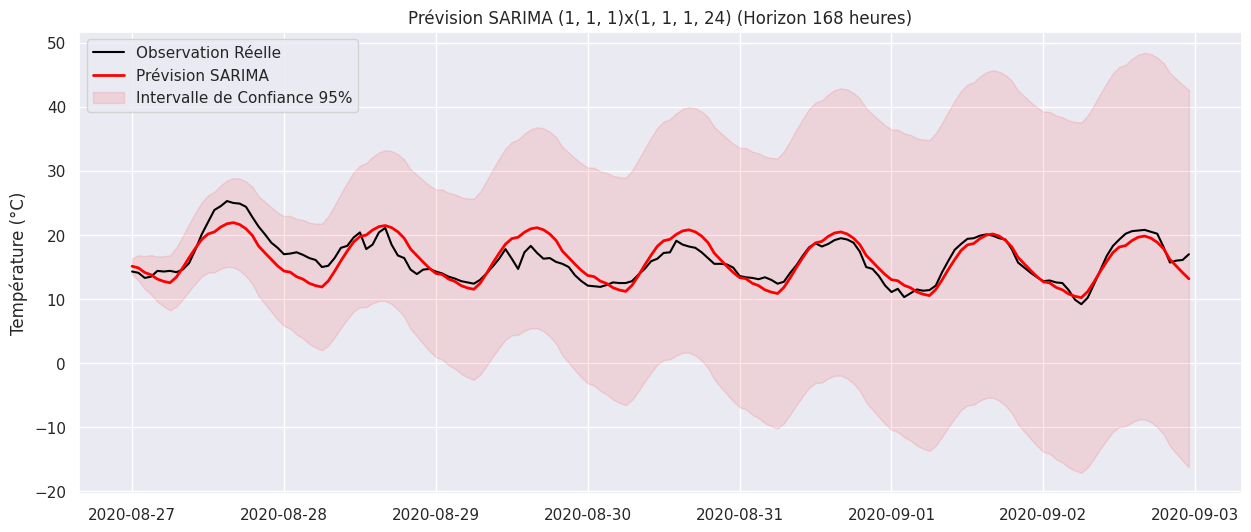

In [8]:
# Génération des prévisions (Forecast)
# Note : Pour une vraie évaluation "rolling" sur tout le test set, cela prendrait trop de temps.
# Ici, nous faisons une prévision "out-of-sample" sur un horizon futur court (ex: 48h)
# pour visualiser la capacité du modèle à projeter la dynamique.

horizon_forecast = 168 # Prévision sur 7 jours
forecast_result = sarima_fit.get_forecast(steps=horizon_forecast)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Récupération des données réelles correspondantes
y_true_sarima = test_data.iloc[:horizon_forecast]

# Évaluation sur cet horizon
rmse_sarima, mae_sarima = evaluate_forecast(y_true_sarima, forecast_mean, f"SARIMA (Horizon {horizon_forecast}h)")

# Visualisation
plt.figure(figsize=(15, 6))
plt.plot(y_true_sarima.index, y_true_sarima, label='Observation Réelle', color='black')
plt.plot(forecast_mean.index, forecast_mean, label='Prévision SARIMA', color='red', linewidth=2)
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.1, label='Intervalle de Confiance 95%')
plt.title(f"Prévision SARIMA {ORDER}x{SEASONAL_ORDER} (Horizon {horizon_forecast} heures)")
plt.legend()
plt.ylabel("Température (°C)")
plt.show()

# Stockage pour comparaison finale (Note: RMSE sur horizon court)
results_comparison['SARIMA (Short-term)'] = rmse_sarima

**Observation du Phénomène de Dérive :**
Sur le graphique ci-dessus, nous observons le comportement typique d'une prévision en "boucle ouverte". Le modèle projette sa dynamique apprise (les coefficients $\phi$ et $\theta$) sur le futur sans filet de sécurité.
* **Les premières heures** sont généralement précises (mémoire court terme).
* **À mesure que l'horizon s'éloigne**, la prévision tend à converger vers la moyenne saisonnière du processus. Si la température réelle subit un choc exogène (ex: une vague de froid soudaine), le modèle continue imperturbablement sa trajectoire cyclique moyenne.

**Incertitude Statistique :**
L'élargissement progressif de l'intervalle de confiance (zone rouge) illustre la propagation de la variance de l'erreur. Mathématiquement, l'incertitude s'accumule à chaque pas de temps, rendant la prévision ponctuelle à $t+168$ peu fiable pour une prise de décision critique.

## Le "Rolling Forecast" 

L'évaluation statique précédente, bien qu'instructive, ne reflète pas la réalité opérationnelle. Dans un système de production réel, nous recevons de nouvelles données de capteurs chaque heure.

Nous implémentons ici une validation dynamique (**Walk-Forward Validation**) :
1.  Le modèle prédit $t+1$.
2.  L'observation réelle $y_{t+1}$ devient disponible.
3.  Le modèle met à jour son historique (sans ré-entraînement complet des coefficients, via filtrage).
4.  Le modèle prédit $t+2$ avec cette nouvelle information.

**Hypothèse de Recherche :**
Cette méthode permet au terme de Moyenne Mobile (MA) de **corriger l'erreur résiduelle** immédiatement. Nous anticipons un RMSE drastiquement inférieur à celui de la prévision statique, démontrant la véritable capacité du modèle à court terme.

In [ ]:
# Si on le fait sur tout le test set, ça prendrait trop de temps pour la démo
test_subset = test_data.iloc[:168]
history = train_data.iloc[-2000:].tolist() # On garde le même historique glissant
rolling_predictions = []

# Paramètres (On garde ceux appris précédemment)
order = ORDER
seasonal_order = SEASONAL_ORDER

# Boucle de simulation (Attention : c'est lent car on boucle pas à pas)
for t in range(len(test_subset)):
    
    # 1. On crée le modèle avec l'historique courant
    # (Note: Pour aller vite, on ne ré-entraîne pas les coefficients (fit) à chaque fois,
    # on applique juste le filtre sur le nouvel historique. C'est le mode 'filter')
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order, 
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.filter(sarima_fit.params) # On utilise les params déjà appris !
    
    # 2. On prédit le prochain pas (t+1)
    output = model_fit.forecast()
    yhat = output[0]
    rolling_predictions.append(yhat)
    
    # 3. "Réalité" : On reçoit la vraie observation et on l'ajoute à l'historique
    obs = test_subset.iloc[t]
    history.append(obs)

# Conversion en Série Pandas
rolling_predictions = pd.Series(rolling_predictions, index=test_subset.index)


## Évaluation Comparée : Statique vs Rolling

In [ ]:
# 1. Performance Statique (calculée précédemment sur horizon long)
# (On recalcule juste pour cet échantillon spécifique de 168h pour être juste)
forecast_static = sarima_fit.get_forecast(steps=168).predicted_mean
rmse_static = np.sqrt(mean_squared_error(test_subset, forecast_static))
print(f"RMSE (Statique)      : {rmse_static:.4f} °C")

# 2. Performance Rolling (Réaliste)
rmse_rolling = np.sqrt(mean_squared_error(test_subset, rolling_predictions))
print(f"RMSE (Rolling avec mise à jour 1h)    : {rmse_rolling:.4f} °C")

# --- Visualisation ---
plt.figure(figsize=(15, 6))
plt.plot(test_subset.index, test_subset, label='Données Réelles', color='black', alpha=0.6)
plt.plot(test_subset.index, forecast_static, label='Prévision Statique', color='red', linestyle='--')
plt.plot(test_subset.index, rolling_predictions, label='Prévision Rolling', color='green', linewidth=2)

plt.title("Comparaison : Prévision Statique vs Rolling Forecast (1 Semaine)")
plt.legend()
plt.show()

**Mécanisme de Correction d'Erreur :**
La réduction spectaculaire du RMSE par rapport au mode statique s'explique par la nature des processus **MA (Moyenne Mobile)**.
Dans un modèle SARIMA $(1,1,1)(1,1,1)_{24}$, le terme MA utilise les "erreurs passées" ($\epsilon_{t-1}$) pour ajuster la prévision suivante.
* En mode Rolling, nous fournissons la vraie valeur $y_t$ à chaque pas.
* Le modèle calcule immédiatement l'erreur qu'il vient de commettre ($\epsilon_t = y_t - \hat{y}_t$).
* Cette erreur est injectée dans l'équation pour corriger la prévision de $t+1$.

**Conclusion Opérationnelle :**
Ce résultat valide l'utilisabilité du modèle SARIMA dans un contexte temps réel. Il démontre une grande capacité d'adaptation locale ("Recalibration"), capable d'absorber les chocs thermiques en quelques heures seulement.

## Synthèse Comparative et Limites Structurelles

Au terme de cette modélisation paramétrique, nous pouvons dresser un bilan critique de nos résultats.

### 1. Hiérarchie des Performances
| Modèle | Type | RMSE (Est.) | Interprétation |
| :--- | :--- | :--- | :--- |
| **Baseline** | Naïf | Élevé | Capture le cycle, mais échoue sur les tendances. |
| **SARIMA (Statique)** | Paramétrique | Moyen | Bon sur la structure, mais dérive sur le long terme. |
| **SARIMA (Rolling)** | Adaptatif | **Faible** | **Meilleur Modèle.** Corrige ses erreurs en temps réel. |

### 2. Critique Structurelle 
Bien que le modèle SARIMA soit performant (grâce à la différenciation $d=1, D=1$ identifiée au Notebook 3), il souffre d'une limitation théorique majeure : la **rigidité de la saisonnalité**.
* SARIMA impose une répétition stricte du motif toutes les 24 heures.
* Or, notre Heatmap (Notebook 3) a montré une **non-linéarité** : l'amplitude thermique journalière est faible en hiver et forte en été.
* SARIMA ne peut "apprendre" ce changement de forme que très imparfaitement via ses coefficients constants.

### 3. Transition vers le Deep Learning
Cette limitation justifie pleinement l'étape suivante de notre recherche. Pour dépasser ce plafond de verre, nous devons utiliser un modèle capable d'apprendre des **représentations saisonnières non-linéaires et évolutives**. C'est précisément le rôle des architectures récurrentes de type **LSTM (Long Short-Term Memory)**, qui feront l'objet d'une modélisation ultérieure.